### ** SENG 550 Final Project **
#### Group 6
Benjamin Nielsen - 30063158

Trevor Brown - 30063456

Will Kerr - 30064999

Ahmed Farazi - 30063552

Sultan Arafat - 30057064

## Create Features and Labels

In [0]:
import time
from datetime import datetime

#### Get Training Features and Labels
This method get_train_features() will get all of our features from the training data. The features that we get are the following in order:

- Date (format in dd-mm-yyyy)
- Hour (the hour in 24 hour time)
- Day of the Week (as a String)
- Distance (Which is the distance between the longitudes added with the distance between the latitutes. The reason we did it like this is since New York is built on a grid, we decided that it would be better if the distance was also considered as a grid)
- Longitude of Pickup
- Latitude of Pickup
- Longitude of Drop off
- Latitude of Drop off


The NYC train data can be gotten from this link: https://www.kaggle.com/c/nyc-taxi-trip-duration/data

This filename that you are looking to download is "train.csv"

In [0]:
#Holds names of all weekdays
day_name = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday','Sunday']
    
def get_train_features(line):
    """
    param: line of training data
    return: list of Features from the line
    """
    ar = line.split(',')
    dt = datetime.strptime(ar[2], '%Y-%m-%d %H:%M:%S')
    return (dt.strftime("%-d-%-m-%Y"),(int(dt.strftime("%H")),dt.weekday(),abs(float(ar[5])-float(ar[7])) + abs(float(ar[6]) - float(ar[8])), float(ar[5]), float(ar[6]), float(ar[7]), float(ar[8]), int(ar[10])))

In [0]:
#Get the training data
train_filename = 'dbfs:/FileStore/shared_uploads/william.kerr@ucalgary.ca/train_sample.csv'
#train_filename = 'dbfs:/FileStore/tables/train_sample.csv'
nyc_train_RDD = (sc.textFile(train_filename, 8))
nyc_train_RDD=nyc_train_RDD.cache()

#Remove Header
header_train = nyc_train_RDD.first() #extract header
nyc_train_RDD = nyc_train_RDD.filter(lambda row: row != header_train)   #filter out header

#Get the features for training
#Here we will filter out all outliers from the training data set
nyc_X_train_RDD = nyc_train_RDD.map(get_train_features).filter(lambda x: x[1][7] < 2000)
print("X_train:")
print(nyc_X_train_RDD.count())
print(nyc_X_train_RDD.take(1))

X_train:
56560
[('14-3-2016', (17, 0, 0.01985931396484375, -73.9821548461914, 40.76793670654297, -73.96463012695312, 40.765602111816406, 455))]


#### Get Weather Features
This method get_weather_features gets all of the features from our weather data. The features are the following:

- Max Temp
- Min Temp
- Average Temp
- Precipitation
- Snow fall
- Snow depth

The method filter_T is used to filter out some of data from the weather data. Some data is labelled as "T" if they did not collect data for that value. We will just assume that value is 0

The weather train data can be gotten from this link: https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016/version/3

This filename that you are looking to download is "weather_data_nyc_centralpark_2016.csv"

In [0]:
def filter_T(arg):
    """
    param: value from weather data
    return: 0 if the input is T, else return the input
    """
    if arg == "T":
        return 0
    else:
        return arg

def get_weather_features(line):
    """
    param: line of weather data
    return: list of Features from the line
    """
    ar = line.split(',')
    
    return (ar[0],(int(ar[1]),int(ar[2]),float(ar[3]),float(filter_T(ar[4])),float(filter_T(ar[5])),int(filter_T(ar[6]))))

In [0]:
#get weather data
weather_filepath = "dbfs:/FileStore/shared_uploads/william.kerr@ucalgary.ca/weather_data_nyc_centralpark_2016.csv"
#weather_filepath = "dbfs:/FileStore/tables/weather_data_nyc_centralpark_2016.csv"
nyc_weather_RDD = (sc.textFile(weather_filepath, 8))

#Remove Header
header_weather = nyc_weather_RDD.first() #extract header
nyc_weather_RDD = nyc_weather_RDD.filter(lambda row: row != header_weather)   #filter out header

#Get the features for weather data
nyc_weather_RDD = nyc_weather_RDD.map(get_weather_features)
print("NYC_Weather:")
print(nyc_weather_RDD.count())
print(nyc_weather_RDD.take(1))

NYC_Weather:
366
[('1-1-2016', (42, 34, 38.0, 0.0, 0.0, 0))]


#### Combine Training and Weather Features
Here we will join our training and weather features on data

In [0]:
#Join the training data and weather data on the date
combined_RDD = nyc_X_train_RDD.join(nyc_weather_RDD)
print("Combined Data:")
print(combined_RDD.count())
print(combined_RDD.take(1))

Combined Data:
56560
[('24-5-2016', ((12, 1, 0.041545867919921875, -73.99409484863281, 40.76155090332031, -73.98063659667969, 40.78963851928711, 720), (73, 58, 65.5, 0.18, 0.0, 0)))]


#### Visualize Training Data

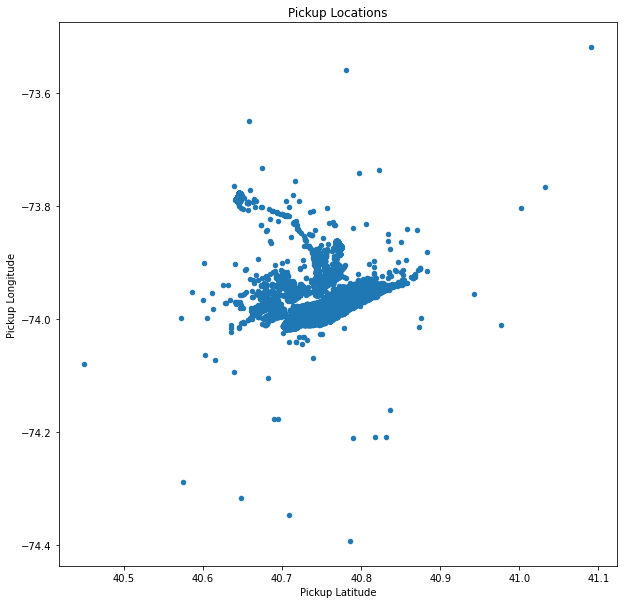

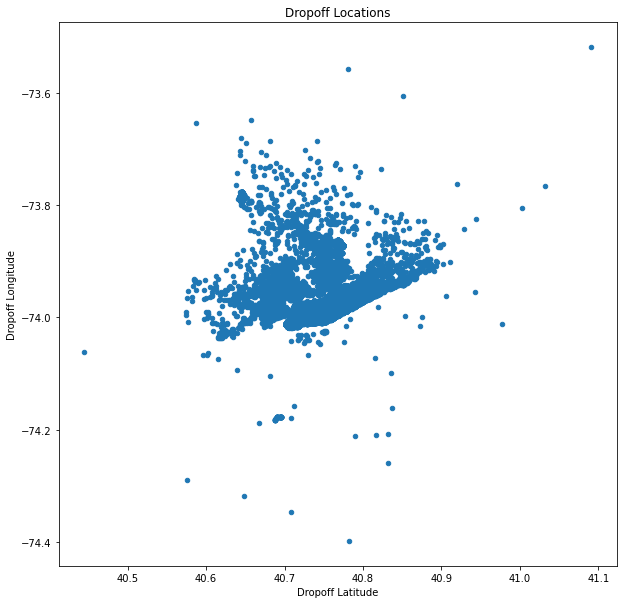

In [0]:
pickup_RDD = combined_RDD.map(lambda x: (x[1][0][4], x[1][0][3]))
pickup_df = pickup_RDD.toDF(['Pickup Latitude','Pickup Longitude']).toPandas()

dropoff_RDD = combined_RDD.map(lambda x: (x[1][0][6], x[1][0][5]))
dropoff_df = dropoff_RDD.toDF(['Dropoff Latitude','Dropoff Longitude']).toPandas()

ax = pickup_df.plot.scatter(x='Pickup Latitude', y='Pickup Longitude', title='Pickup Locations', figsize=(10,10))
ax = dropoff_df.plot.scatter(x='Dropoff Latitude', y='Dropoff Longitude', title='Dropoff Locations', figsize=(10,10))

#### Create Labeled Points
Here we will combined our labels from the training set and our combined training and weather features

In [0]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

In [0]:
def parsePoint(line):
    """
    param: One line of the combined features list
    """
    # takes lines in the form (date, ((hour, weekday, dist, duration), (max t, min t, av t, perc, snowfall, snow on ground))
    # outputs in the form (label, [features])
    tf = line[1][0]
    tf = list(tf)
    tf.pop()
    tf = [time.mktime(datetime.strptime(line[0], '%d-%m-%Y').timetuple())] + tf
    wf = line[1][1]
    
    features = tf + list(wf)
    return LabeledPoint(line[1][0][7], features)

In [0]:
parsed_sample_points_RDD = combined_RDD.map(parsePoint)
print("Parsed and formatted combined data:")
print(parsed_sample_points_RDD.count())
print(parsed_sample_points_RDD.take(2))

Parsed and formatted combined data:
56560
[LabeledPoint(720.0, [1464048000.0,12.0,1.0,0.041545867919921875,-73.99409484863281,40.76155090332031,-73.98063659667969,40.78963851928711,73.0,58.0,65.5,0.18,0.0,0.0]), LabeledPoint(1133.0, [1464048000.0,13.0,1.0,0.02201080322265625,-73.97869873046875,40.755210876464844,-73.98822784423828,40.74272918701172,73.0,58.0,65.5,0.18,0.0,0.0])]


## Normalize all Features

Here we will normalize each value of the features individually

In [0]:
def normalizeFeatures(lp):
    n_feats = []
    for i in range(0, len(lp.features)):
        feature = (lp.features[i] - bc_mean.value[i]) / bc_stdev.value[i]
        n_feats.append(feature)
    return LabeledPoint(lp.label, n_feats)

    
def getNormalizedRDD(rdd):
    means = []
    stdevs = []
    num_f = len(rdd.take(1)[0].features)
    for i in range(0, num_f):
        f_RDD = rdd.map(lambda lp: lp.features[i])
        means.append(f_RDD.mean())
        stdevs.append(f_RDD.stdev())
        
    global bc_mean
    bc_mean = sc.broadcast(means)
    global bc_stdev
    bc_stdev = sc.broadcast(stdevs)
    return rdd.map(normalizeFeatures)

In [0]:
normalized_points_RDD = getNormalizedRDD(parsed_sample_points_RDD)
print(normalized_points_RDD.take(1))

[LabeledPoint(720.0, [1.0460833053864242,-0.24632219199985578,-1.0444682487820907,0.10230544054783414,-0.5796954685387615,0.35597062680538366,-0.18216258514026137,1.2260743760548707,0.8128690742276945,0.9791665650750566,0.9027233087152369,0.35941255724232385,-0.066314255882966,-0.1824275352753679])]


## Get Training, Validiation and Testing Data
We will use the following split:

- 75% Training Data
- 25% Testing Data

In [0]:
weights = [.75, .25] # train/test split     
seed = 0

parsed_train_data_RDD, parsed_test_data_RDD = normalized_points_RDD.randomSplit(weights,seed)

#Cache the following data into memory
parsed_train_data_RDD.cache()
parsed_test_data_RDD.cache()

#Size of each data split
nTrain = parsed_train_data_RDD.count()
nTest = parsed_test_data_RDD.count()

print("Sample Training Data: ", parsed_train_data_RDD.take(1))
print("train:", nTrain, ", Test:", nTest, ", All:", nTrain + nTest)
print("RDD count:", normalized_points_RDD.count())

Sample Training Data:  [LabeledPoint(720.0, [1.0460833053864242,-0.24632219199985578,-1.0444682487820907,0.10230544054783414,-0.5796954685387615,0.35597062680538366,-0.18216258514026137,1.2260743760548707,0.8128690742276945,0.9791665650750566,0.9027233087152369,0.35941255724232385,-0.066314255882966,-0.1824275352753679])]
train: 42390 , Test: 14170 , All: 56560
RDD count: 56560


## Create Baseline

First we will create a baseline which we will compare all of our models against. The baseline we will use will just be the average of all of the trips.

In [0]:
#get the average of all the trips
average_trip_duration = (parsed_train_data_RDD.map(lambda s: s.label)).mean()
print(average_trip_duration)

721.0750412833216


### Evaluate the Baseline

In [0]:
from pyspark.mllib.evaluation import RegressionMetrics

#Create a list of all of the test labels
test_labels = parsed_test_data_RDD.map(lambda x: x.label).collect()

#Create a map with the labels and the average trip duration
#labels_and_preds_train = parsed_train_data_RDD.map(lambda s: (s.label, average_trip_duration))

baselinePredictions = [average_trip_duration] * parsed_test_data_RDD.count()

#Evaluate the Baseline
# calculate mean squared error
baseline_mse = np.mean((np.array(baselinePredictions) - np.array(test_labels)) ** 2)
# calculate root mean squared error
baseline_rmse = np.sqrt(baseline_mse)
# calcuate mean absolute error
baseline_mae = np.sum(np.absolute(np.array(baselinePredictions) - np.array(test_labels)))
# calculate coefficient of determination

# display evaluation metrics
print("Mean Squared Error = %s" % baseline_mse)
print("Root Mean Squared Error = %s" % baseline_rmse)
print("Mean Absolute Error = %s" % baseline_mae)

#Get the metrics of the accuracy of our baseline
#metrics = RegressionMetrics(labels_and_preds_train)

#print("MSE = ", metrics.meanSquaredError)
#print("RMSE = ", metrics.rootMeanSquaredError)

Mean Squared Error = 187017.4355879672
Root Mean Squared Error = 432.45512551936207
Mean Absolute Error = 4969071.392639774


## Linear Regression Model
Our first model will be a linear regression model

We will use the following as our default parameters

In [0]:
from pyspark.mllib.regression import LinearRegressionWithSGD

num_iters = 500
alpha = 1.0
mini_batch_frac = 1.0
reg = 1e-1
reg_type = 'l2'
use_intercept = True

#### Train Linear Regression Model
Here we will train our model and determine the weights of each feature

In [0]:
import pandas as pd

def graphWeights(weights_list):
    df = pd.DataFrame({'feature':['Date','Hour','Day of Week','Distance','Pickup Longitude','Pickup Latitude','Dropoff Longitude','Dropoff Latitude','Max Temp','Min Temp','Average Temp','Precipitation','Snow Fall','Snow Depth'], 'weight':weights_list})
    ax = df.plot.bar(x='feature',y='weight', rot=0, title='Feature Weights', figsize=(25,7))

[14.285039862664284,26.0495163775653,-17.542506603804423,311.39030517894446,-46.93930707667548,22.329195865660036,-21.13330384345878,-27.077483632419586,-1.8783035217991348,7.604765884341719,2.587014055509533,-9.984840926499377,5.647942189424005,11.825189391725065] 720.8371201299905


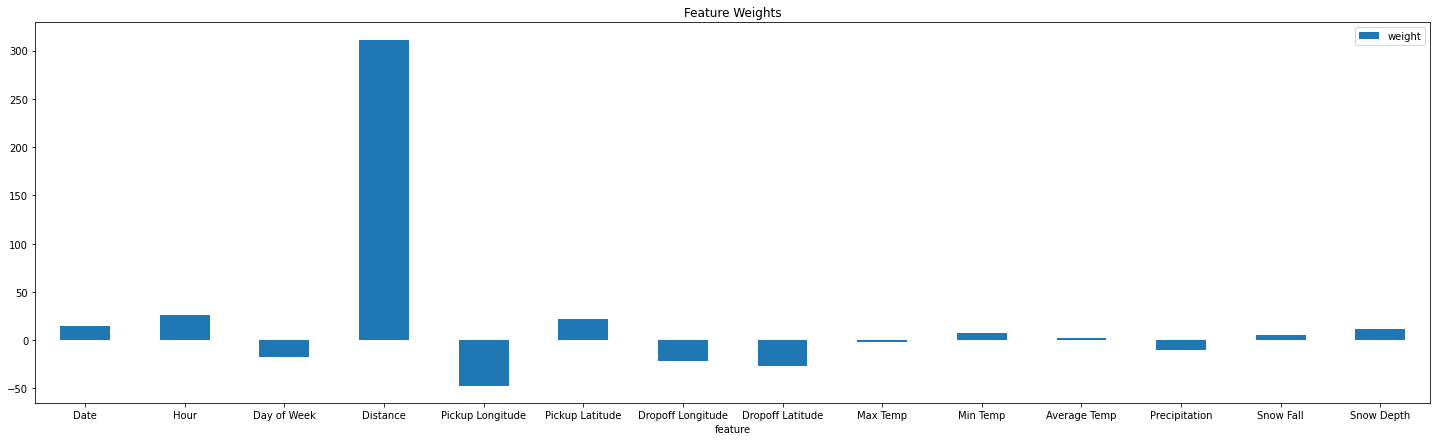

In [0]:
#Train model
lr_model = LinearRegressionWithSGD.train(parsed_train_data_RDD, num_iters, alpha, mini_batch_frac, initialWeights=None, regParam=reg, intercept=use_intercept)

#Get the weights and intercept
weights_LR1 = lr_model.weights
intercept_LR1 = lr_model.intercept
print(weights_LR1, intercept_LR1)

graphWeights(weights_LR1)

Here is a sample of how close this linear regression model is to the correct answer:

In [0]:
#I MADE A CHANGE HERE..............................................

# sample_point = parsed_train_data_RDD.take(1)[0]
# print(sample_point)
# sample_prediction = lr_model.predict(sample_point.features)
# print("Predict:",sample_prediction)
# print("True:",sample_point.label)


linear_predictions = lr_model.predict(parsed_test_data_RDD.map(lambda x: x.features)).collect()



#### Evaluate Linear Regression Model

In [0]:
import pandas as pd

# this function will be used to evaluate all models
def evaluate_model(predictions, name, cv):
    # calculate mean squared error
    mse = np.mean((np.array(predictions) - np.array(test_labels)) ** 2)
    # calculate root mean squared error
    rmse = np.sqrt(mse)
    # calcuate mean absolute error
    mae = np.sum(np.absolute(np.array(predictions) - np.array(test_labels)))
    # calculate coefficient of determination
    cd = np.corrcoef(predictions, test_labels)[0, 1] ** 2
    # calculate explained variance
    ev = 1 - (np.var(np.array(predictions) - np.array(test_labels)) / np.var(predictions))
    
    eval_df = pd.DataFrame({"Model":[name], "Cross_Validation":[cv], "MSE":[mse], "RMSE":[rmse], "MAE":[mae], "R-Sqaured":[cd], "Explained Variance":[ev]})
    display(eval_df)
    return eval_df
    # display evaluation metrics
    #print("Mean Squared Error = %s" % mse)
    #print("Root Mean Squared Error = %s" % rmse)
    #print("Mean Absolute Error = %s" % mae)
    #print("Coefficient of Determination (R^2) = %s" % cd)
    #print("Explained Variance = %s" % ev)

In [0]:
# labels_and_preds_train_LR1 = parsed_test_data_RDD.map(lambda lp: (lp.label, float(lr_model.predict(lp.features))))
# metrics_LR1 = RegressionMetrics(labels_and_preds_train_LR1)

# print("MSE = ", metrics_LR1.meanSquaredError)
# print("RMSE = ", metrics_LR1.rootMeanSquaredError)

lr_predictions = lr_model.predict(parsed_test_data_RDD.map(lambda x: x.features)).collect()

lr_eval_df = evaluate_model(lr_predictions,"Linear Regression", "No")

Model,Cross_Validation,MSE,RMSE,MAE,R-Sqaured,Explained Variance
Linear Regression,No,101017.93144686769,317.833181790177,3472243.8809020906,0.4602485080073907,-0.2451866170150261


/databricks/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Out[22]: Text(0.5, 1.0, 'Linear Regression VS Test Labels')

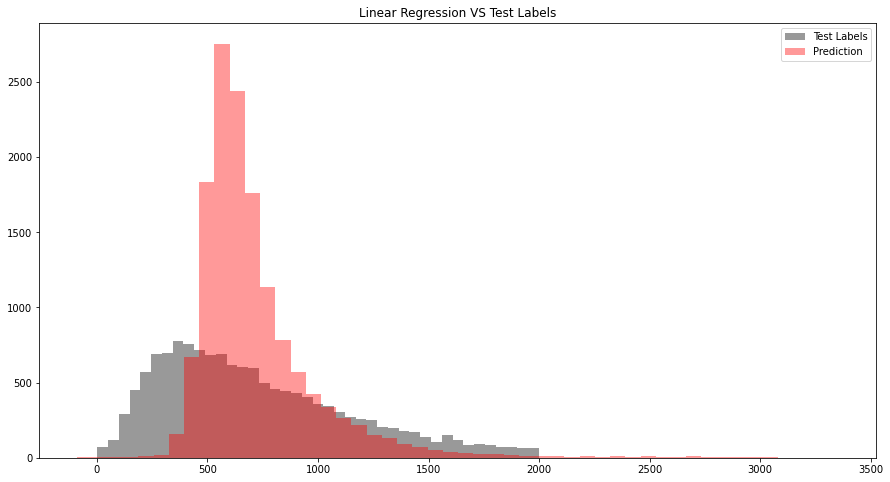

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(test_labels, kde=False, color="black", label="Test Labels")

plt.subplot(1,1,1)
sns.distplot(lr_predictions, kde=False, color="r", label="Prediction")
plt.legend()
plt.title("Linear Regression VS Test Labels")

### Perform Cross Validation on Linear Regression Model
This step performs hyper parameter tuning to optimize the paramters for the linear regression model.
The methodology for this step was based on the following resource: https://www.sparkitecture.io/machine-learning/regression/linear-regression

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

#transforming labelled point train RDD to dataframe
train_df = parsed_train_data_RDD.map(lambda x: (x.label,x.features))
train_df = train_df.map(lambda x: (x[0],Vectors.dense(x[1].tolist()))).toDF(["label","features"])

#transforming labelled point test RDD to dataframe
test_df = parsed_test_data_RDD.map(lambda x: (x.label,x.features))
test_df = test_df.map(lambda x: (x[0],Vectors.dense(x[1].tolist()))).toDF(["label","features"])

#We will hypertune the following linear regression model
lr = LinearRegression(labelCol="label", featuresCol="features")

#We create a parameter grid for all of the parameters we will be altering for the model
lr_paramGrid = (ParamGridBuilder()
               #.addGrid(lr.regParam, [0.001, 0.01, 0.1, 0.5, 1.0, 2.0])
               #.addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
               #.addGrid(lr.maxIter, [1, 5, 10, 20, 50])
               .addGrid(lr.regParam, [0.01, 0.1, 0.5])
               .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
               .addGrid(lr.maxIter, [1, 5, 10])
             .build())
        
#We use this evaluator to evaluate or model based on RMSE
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
               
# Create 5-fold CrossValidator
lr_cv = CrossValidator(estimator = lr,
                    estimatorParamMaps = lr_paramGrid,
                    evaluator = lr_evaluator,
                    numFolds = 5)
               
#Fit the new model with the training data
lr_cv_model = lr_cv.fit(train_df)

/databricks/spark/python/pyspark/ml/util.py:839: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
  warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)


In [0]:
#Determine predictions from the test data
lr_cv_predictions = lr_cv_model.transform(test_df)

#We turn the dataframe into a list for displaying values
lr_cv_predictions_list = [int(row.prediction) for row in lr_cv_predictions.select('prediction').collect()]

#Evaluate the cross validated linear regression model
lr_cv_eval_df = evaluate_model(lr_cv_predictions_list,"Linear Regression", "Yes")

Model,Cross_Validation,MSE,RMSE,MAE,R-Sqaured,Explained Variance
Linear Regression,Yes,100959.1850388144,317.7407513033454,3467216.0,0.4604556504960972,-0.23186309550458617


Out[25]: Text(0.5, 1.0, 'Cross-Validated Linear Regression VS Test Labels')

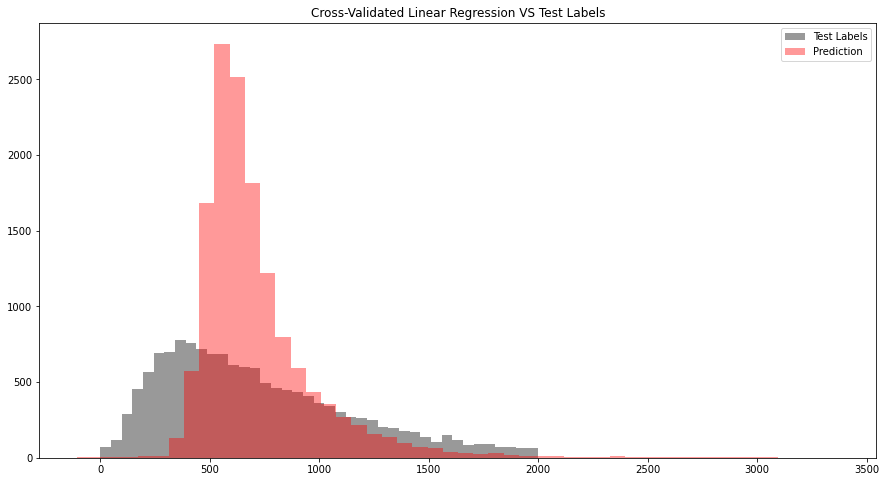

In [0]:
plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(test_labels, kde=False, color="black", label="Test Labels")

plt.subplot(1,1,1)
sns.distplot(lr_cv_predictions_list, kde=False, color="r", label="Prediction")
plt.legend()
plt.title("Cross-Validated Linear Regression VS Test Labels")

## Random Forest Model

Our second model will be a random forest model. We know this wil underperform as it does not address the overfitting of the linear regression, but it is useful for comparison

We will evaluate this model based on RMSE

In [0]:
from pyspark.mllib.tree import RandomForest
from pyspark.ml.evaluation import RegressionEvaluator

rf_model = RandomForest.trainRegressor(parsed_train_data_RDD, categoricalFeaturesInfo={},
                                      numTrees=8, featureSubsetStrategy='auto',
                                      impurity='variance', maxDepth=5, maxBins=32)

rf_predictions = rf_model.predict(parsed_test_data_RDD.map(lambda x: x.features)).collect()

### Evaluate Random Forest Model

In [0]:
rf_eval_df = evaluate_model(rf_predictions,"Random Forest", "No")

Model,Cross_Validation,MSE,RMSE,MAE,R-Sqaured,Explained Variance
Random Forest,No,79235.48619036001,281.48798587215055,3061563.5135435546,0.5804287898989509,0.13087830566706204


Out[28]: Text(0.5, 1.0, 'Random Forest VS Test Labels')

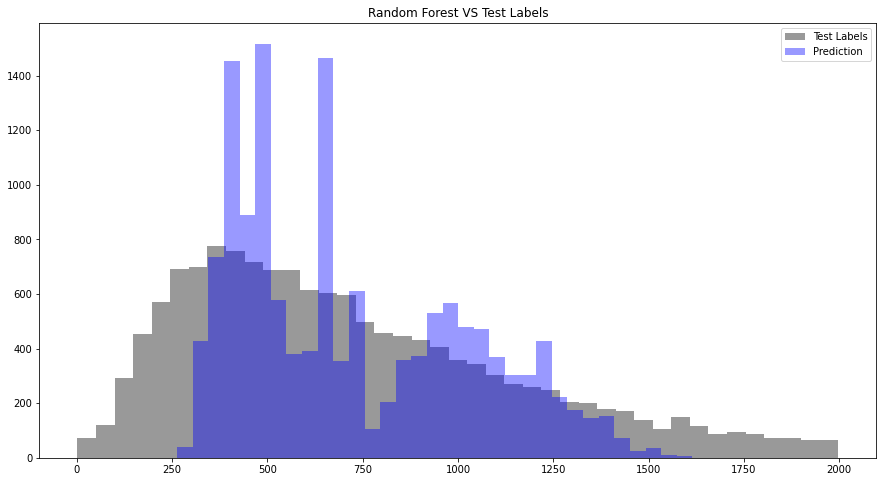

In [0]:
plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(test_labels, kde=False, color="black", label="Test Labels")

plt.subplot(1,1,1)
sns.distplot(rf_predictions, kde=False, color="b", label="Prediction")
plt.legend()
plt.title("Random Forest VS Test Labels")

### Perform Cross Validation on Random Forest Model
This step performs hyper parameter tuning to optimize the paramters for the random forest model.
The methodology for this step was based on the following resource: https://www.sparkitecture.io/machine-learning/regression/random-forest

In [0]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="label", featuresCol="features")

rf_paramGrid = (ParamGridBuilder()
             #.addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
             #.addGrid(rf.maxBins, [10, 20, 40, 80, 100])
             #.addGrid(rf.numTrees, [5, 20, 50, 100, 500])
               .addGrid(rf.maxDepth, [5])
               .addGrid(rf.maxBins, [10])
               .addGrid(rf.numTrees, [20])
             .build())

rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")

# Create 5-fold CrossValidator
rf_cv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rf_paramGrid,
                      evaluator = rf_evaluator,
                      numFolds = 5)

rf_cv_model = rf_cv.fit(train_df)

In [0]:
#Determine predictions from the test data
rf_cv_predictions = rf_cv_model.transform(test_df)

#We turn the dataframe into a list for displaying values
rf_cv_predictions_list = [int(row.prediction) for row in rf_cv_predictions.select('prediction').collect()]

#Evaluate the cross validated linear regression model
rf_cv_eval_df = evaluate_model(rf_cv_predictions_list,"Random Forest", "Yes")

Model,Cross_Validation,MSE,RMSE,MAE,R-Sqaured,Explained Variance
Random Forest,Yes,83732.84798870854,289.36628689035035,3170612.0,0.5640884665832977,-0.0848401531733276


Out[31]: Text(0.5, 1.0, 'Cross Validated Random Forest VS Test Labels')

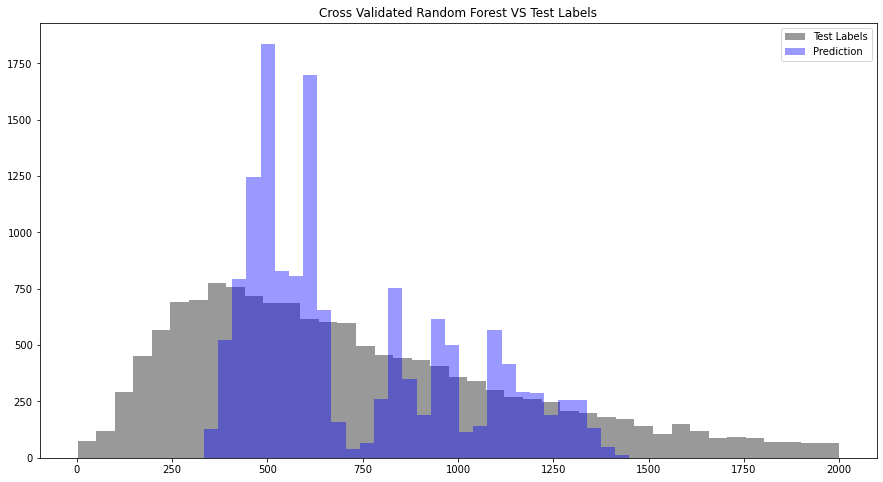

In [0]:
plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(test_labels, kde=False, color="black", label="Test Labels")

plt.subplot(1,1,1)
sns.distplot(rf_cv_predictions_list, kde=False, color="b", label="Prediction")
plt.legend()
plt.title("Cross Validated Random Forest VS Test Labels")

## Gradient Boosted Trees Model

Our third model will be an gradient boosted trees model. This decision tree model outperforms Random Forest.

In [0]:
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.util import MLUtils

categoricalFeaturesInfo={0:2, 1:2, 2:6, 3:4}
gbt_model = GradientBoostedTrees.trainRegressor(parsed_train_data_RDD, categoricalFeaturesInfo={}, 
                                                numIterations=10, maxBins=32, maxDepth = 4, learningRate=0.1)

gbt_predictions = gbt_model.predict(parsed_test_data_RDD.map(lambda x: x.features)).collect()

### Evaluate Gradient Boosted Trees Model

In [0]:
gb_eval_df = evaluate_model(gbt_predictions,"Gradient Boosted Trees", "No")

Model,Cross_Validation,MSE,RMSE,MAE,R-Sqaured,Explained Variance
Gradient Boosted Trees,No,69722.28276962151,264.0497732807614,2819859.5558256744,0.6274739851324903,0.38092516957850464


Out[34]: Text(0.5, 1.0, 'Gradient Boosted Trees VS Test Labels')

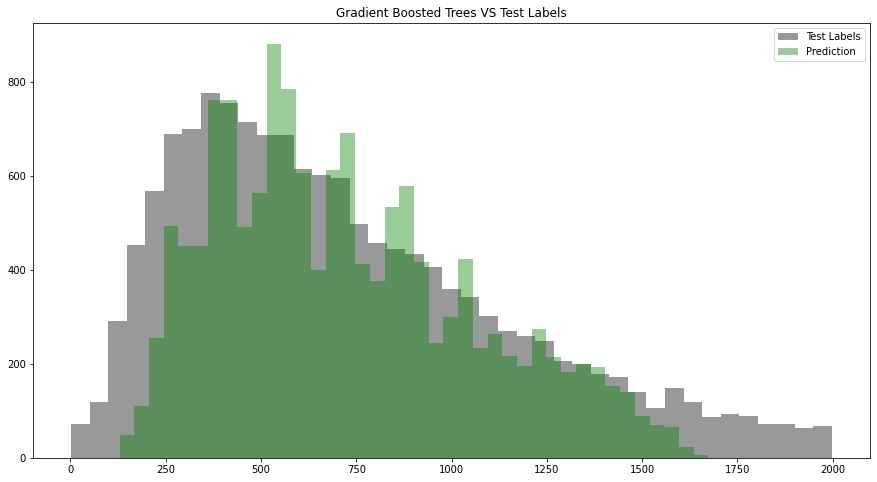

In [0]:
plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(test_labels, kde=False, color="black", label="Test Labels")

plt.subplot(1,1,1)
sns.distplot(gbt_predictions, kde=False, color="g", label="Prediction")
plt.legend()
plt.title("Gradient Boosted Trees VS Test Labels")

### Perform Cross Validation on Gradient Boosted Trees Model
This step performs hyper parameter tuning to optimize the paramters for the gradient boosted trees model.
The methodology for this step was based on the following resource: https://www.sparkitecture.io/machine-learning/regression/gradient-boosted-trees

In [0]:
from pyspark.ml.regression import GBTRegressor

gb = GBTRegressor(labelCol="label", featuresCol="features")

gb_paramGrid = (ParamGridBuilder()
#             .addGrid(gb.maxDepth, [2, 5, 10])
#             .addGrid(gb.maxBins, [10, 20, 40])
#             .addGrid(gb.maxIter, [5, 10, 20])
             .addGrid(gb.maxDepth, [5])
             .addGrid(gb.maxBins, [20])
             .addGrid(gb.maxIter, [10])
             .build())

gb_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
# Create 5-fold CrossValidator
gb_cv = CrossValidator(estimator = gb,
                      estimatorParamMaps = gb_paramGrid,
                      evaluator = gb_evaluator,
                      numFolds = 5)
gb_cv_model = gb_cv.fit(train_df)

In [0]:
#Determine predictions from the test data
gb_cv_predictions = gb_cv_model.transform(test_df)

#We turn the dataframe into a list for displaying values
gb_cv_predictions_list = [int(row.prediction) for row in gb_cv_predictions.select('prediction').collect()]

#Evaluate the cross validated linear regression model
gb_cv_eval_df = evaluate_model(gb_cv_predictions_list,"Gradient Boosted Trees", "Yes")

Model,Cross_Validation,MSE,RMSE,MAE,R-Sqaured,Explained Variance
Gradient Boosted Trees,Yes,68786.26429075512,262.2713562148088,2787111.0,0.6322241267460752,0.410147173607203


Out[37]: Text(0.5, 1.0, 'Cross Validated Gradient Boosted Trees VS Test Labels')

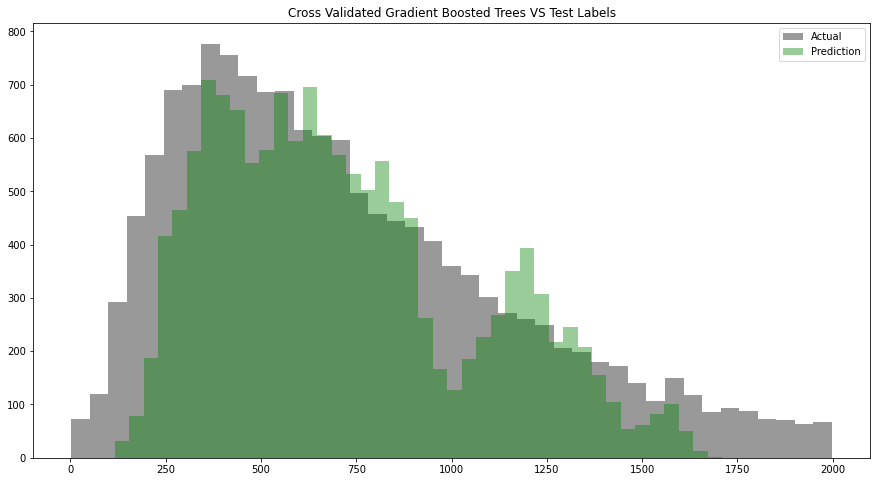

In [0]:
plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(test_labels, kde=False, color="black", label="Actual")

plt.subplot(1,1,1)
sns.distplot(gb_cv_predictions_list, kde=False, color="g", label="Prediction")
plt.legend()
plt.title("Cross Validated Gradient Boosted Trees VS Test Labels")

### Comparison of different models
Here we will illustrate the difference in quality between the 3 models

In [0]:
comparison_df = lr_eval_df.append(lr_cv_eval_df).append(rf_eval_df).append(rf_cv_eval_df).append(gb_eval_df).append(gb_cv_eval_df)
display(comparison_df)

Model,Cross_Validation,MSE,RMSE,MAE,R-Sqaured,Explained Variance
Linear Regression,No,101017.93144686769,317.833181790177,3472243.8809020906,0.4602485080073907,-0.2451866170150261
Linear Regression,Yes,100959.1850388144,317.7407513033454,3467216.0,0.4604556504960972,-0.23186309550458617
Random Forest,No,79235.48619036001,281.48798587215055,3061563.5135435546,0.5804287898989509,0.13087830566706204
Random Forest,Yes,83732.84798870854,289.36628689035035,3170612.0,0.5640884665832977,-0.0848401531733276
Gradient Boosted Trees,No,69722.28276962151,264.0497732807614,2819859.5558256744,0.6274739851324903,0.38092516957850464
Gradient Boosted Trees,Yes,68786.26429075512,262.2713562148088,2787111.0,0.6322241267460752,0.410147173607203


Out[39]: Text(0.5, 1.0, 'Comparision of Models Without Cross Validation')

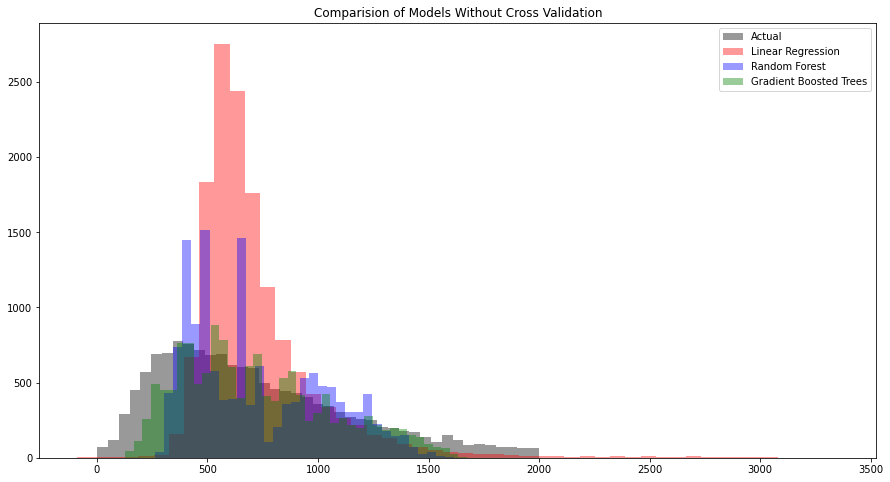

In [0]:
plt.figure(figsize=(15,8))

plt.subplot(1,1,1)
sns.distplot(test_labels, kde=False, color="black", label="Actual")

plt.subplot(1,1,1)
sns.distplot(lr_predictions, kde=False, color="r", label="Linear Regression")

plt.subplot(1,1,1)
sns.distplot(rf_predictions, kde=False, color="b", label="Random Forest")

plt.subplot(1,1,1)
sns.distplot(gbt_predictions, kde=False, color="g", label="Gradient Boosted Trees")

plt.legend()
plt.title("Comparision of Models Without Cross Validation")

Out[40]: Text(0.5, 1.0, 'Comparision of Models With Cross Validation')

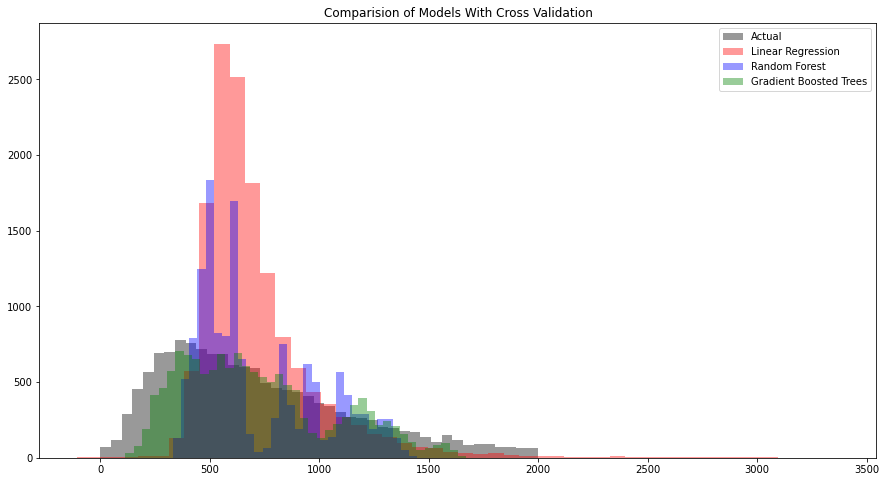

In [0]:
plt.figure(figsize=(15,8))

plt.subplot(1,1,1)
sns.distplot(test_labels, kde=False, color="black", label="Actual")

plt.subplot(1,1,1)
sns.distplot(lr_cv_predictions_list, kde=False, color="r", label="Linear Regression")

plt.subplot(1,1,1)
sns.distplot(rf_cv_predictions_list, kde=False, color="b", label="Random Forest")

plt.subplot(1,1,1)
sns.distplot(gb_cv_predictions_list, kde=False, color="g", label="Gradient Boosted Trees")

plt.legend()
plt.title("Comparision of Models With Cross Validation")